# Importation des bibliothèques 

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer  # Pour vectorisation du texte avec TF-IDF
from sklearn.model_selection import GridSearchCV  # Pour la recherche de grille
import gensim
# from gensim.models.coherencemodel import CoherenceModel
import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# from sklearn.model_selection import train_test_split
# import ast
import pickle

from sklearn.model_selection import GridSearchCV
from joblib import parallel_backend

import warnings
# Filtrer les avertissements
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

# from sklearn.feature_extraction.text import TfidfVectorizer
import init as func

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bille\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bille\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bille\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Charger les données nettoyées:

#### Dataframe df:

In [2]:
df = pd.read_csv('Data/stack_overflow_data_cleaned.csv')
display(df.head())
print(df.shape)

,Id,cleaned_title,cleaned_body,combined_title_body,split_tags
0,2003505,delete git branch,attempt delete remote branch delete branch,delete git branch attempt delete remote branch...,"['git', 'version', 'control', 'git', 'branch',..."
1,16956810,file text string linux,file string text file content display file system,file text string linux file string text file c...,"['linux', 'text', 'grep', 'directory', 'find']"
2,1125968,force git pull overwrite file,force overwrite file repository contains file ...,force git pull overwrite file force overwrite ...,"['git', 'version', 'control', 'overwrite', 'gi..."
3,4366730,check string contains word,suppose code correct write statement,check string contains word suppose code correc...,"['php', 'string', 'substring', 'contains', 'st..."
4,11346283,column name panda,change column label panda dataframe,column name panda change column label panda da...,"['python', 'pandas', 'replace', 'dataframe', '..."


(50000, 5)


#### Les valeurs maqnuantes pour df:

In [3]:
func.taux_de_Remplissage_tableau(df, affichage_all = True)

,Colonne,Taux_de_Remplissage
0,Id,100.000
1,combined_title_body,100.000
2,split_tags,100.000
3,cleaned_title,99.952
4,cleaned_body,99.764


#### Train_df:

In [4]:
train_df = pd.read_csv("Data/stack_overflow_data_cleaned_train.csv")
display(train_df.head())
print(train_df.shape)

,Id,cleaned_title,cleaned_body,combined_title_body,split_tags
0,19245853,xcode iphone simulator look iphone,question device appearance iphone simulator xc...,xcode iphone simulator look iphone question de...,"['ios', 'iphone', 'xcode', 'ios', 'simulator',..."
1,55921515,building dockerfile aptget update jailing proc...,docker host ubuntu docker snap dockerfile comm...,building dockerfile aptget update jailing proc...,"['docker', 'ubuntu', 'nginx', 'dockerfile', 'a..."
2,72575793,aadsts9002326 crossorigin token redemption isi...,send cross origin request access token react s...,aadsts9002326 crossorigin token redemption isi...,"['javascript', 'reactjs', 'webpack', 'axios', ..."
3,11489824,choose tesseract opencv,tesseract opencv look tesseract ocr engine ope...,choose tesseract opencv tesseract opencv look ...,"['python', 'opencv', 'computer', 'vision', 'oc..."
4,3489041,mysqlerror key max key length byte,cause database,mysqlerror key max key length byte cause database,"['mysql', 'sql', 'ruby', 'on', 'rails', 'index..."


(40000, 5)


#### Les valeurs manquantes pour train_df:

In [5]:
func.taux_de_Remplissage_tableau(train_df, affichage_all = True)

,Colonne,Taux_de_Remplissage
0,Id,100.0000
1,combined_title_body,100.0000
2,split_tags,100.0000
3,cleaned_title,99.9475
4,cleaned_body,99.7550


#### Test_df:

In [6]:
test_df = pd.read_csv("Data/stack_overflow_data_cleaned_test.csv")
display(test_df.head())
print(test_df.shape)

,Id,cleaned_title,cleaned_body,combined_title_body,split_tags
0,32177764,weight_decay meta parameter caffe,bvlccaffe git training meta parameter meta par...,weight_decay meta parameter caffe bvlccaffe gi...,"['machine', 'learning', 'neural', 'network', '..."
1,35870760,pyspark dataframe sqllike clause,filter pyspark dataframe sqllike clause tuple ...,pyspark dataframe sqllike clause filter pyspar...,"['python', 'sql', 'apache', 'spark', 'datafram..."
2,10679214,set contenttype header httpclient request,set header object api allows header try throw ...,set contenttype header httpclient request set ...,"['c#', 'aspnet', 'rest', 'content', 'type', 'd..."
3,22157596,aspnet web api operationcanceledexception brow...,user load page ajax request hit aspnet web api...,aspnet web api operationcanceledexception brow...,"['aspnet', 'iis', 'aspnet', 'web', 'api', 'tas..."
4,6100573,draw line object,line control window form draw line line,draw line object line control window form draw...,"['c#', 'winforms', 'user', 'interface', 'drawi..."


(10000, 5)


#### Les valeurs manquantes pour test_df:

In [7]:
func.taux_de_Remplissage_tableau(test_df, affichage_all = True)

,Colonne,Taux_de_Remplissage
0,Id,100.00
1,combined_title_body,100.00
2,split_tags,100.00
3,cleaned_title,99.97
4,cleaned_body,99.80


#### Suppression des valeurs manquantes sur la colonne cleaned_title

In [8]:
df = df.dropna()
train_df = train_df.dropna()
test_df = test_df.dropna()

In [9]:
print("La taille du dataset df après suppressions des valeurs manquantes : ", df.shape)
print("La taille du dataset train_df après suppressions des valeurs manquantes : ", train_df.shape)
print("La taille du dataset test_df après suppressions des valeurs manquantes : ", test_df.shape)

La taille du dataset df après suppressions des valeurs manquantes :  (49858, 5)
La taille du dataset train_df après suppressions des valeurs manquantes :  (39881, 5)
La taille du dataset test_df après suppressions des valeurs manquantes :  (9977, 5)


In [10]:
# Combiner tout le contenu des corps de texte nettoyés en une seule chaîne de texte
corpus_combined_title_body = " ".join(df['combined_title_body'].values).lower()

# Afficher une petite phrase avec les 10 premiers mots du corpus des corps de texte nettoyés
corpus_combined_title_body_tokens = corpus_combined_title_body.split()
print("Les 10 premiers mots du corpus des corps de texte nettoyés sont :", corpus_combined_title_body_tokens[:10])

# Afficher le nombre total de mots du corpus Body
print("Le nombre total de mots du corpus Body est :", len(corpus_combined_title_body))

Les 10 premiers mots du corpus des corps de texte nettoyés sont : ['delete', 'git', 'branch', 'attempt', 'delete', 'remote', 'branch', 'delete', 'branch', 'file']
Le nombre total de mots du corpus Body est : 11738292


In [11]:
# Afficher la fréquence de chaque mot dans le corpus des corps de texte nettoyés
value_counts_combined_title_body = pd.Series(corpus_combined_title_body_tokens).value_counts()
print("Fréquence de chaque mot dans le corpus des corps de texte nettoyés :\n", value_counts_combined_title_body)

Fréquence de chaque mot dans le corpus des corps de texte nettoyés :
 file                        23986
error                       21984
code                        21726
use                         18753
data                        10983
                            ...  
intances                        1
filesjavajre7libtoolsjar        1
filesjavajdk170_51              1
filesx86javajdk170_51           1
instanttoepochmilli             1
Length: 76835, dtype: int64


In [12]:
vocabulary = list(value_counts_combined_title_body.head(300).index)
print(vocabulary)

['file', 'error', 'code', 'use', 'data', 'value', 'server', 'function', 'method', 'class', 'user', 'set', 'application', 'image', 'object', 'time', 'project', 'string', 'help', 'app', 'page', 'python', 'table', 'change', 'question', 'line', 'test', 'window', 'type', 'found', 'command', 'database', 'array', 'request', 'java', 'column', 'thanks', 'version', 'list', 'solution', 'issue', 'try', 'result', 'button', 'return', 'look', 'text', 'android', 'view', 'update', 'web', 'message', 'read', 'query', 'script', 'number', 'output', 'element', 'sql', 'api', 'library', 'spring', 'html', 'json', 'simple', 'key', 'access', 'case', 'edit', 'idea', 'service', 'form', 'javascript', 'build', 'field', 'row', 'right', 'thing', 'client', 'post', 'property', 'url', 'input', 'date', 'jquery', 'convert', 'option', 'install', 'browser', 'exception', 'link', 'php', 'check', 'controller', 'parameter', 'answer', 'click', 'content', 'default', 'program', 'load', 'folder', 'point', 'understand', 'multiple', '

#### Création des vectoriseurs

In [13]:
# tfidf_vectorizer = TfidfVectorizer(vocabulary=vocabulary)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Vectorisation TF-IDF avec un maximum de 5000 caractéristiques


#### Vectoriser les textes des questions avec tfidf_vectorizer

In [14]:
# Transformation des données (train_df et test_df doivent être définis précédemment dans le code)
tfidf_vectorizer.fit(train_df['cleaned_title'])  # Fit sur les titres des données d'entraînement
bow_train_combined = func.tfidf_vectorizer_transform(train_df['combined_title_body'],tfidf_vectorizer ) # Transformation des titres + corps des données d'entraînement
bow_test_combined = func.tfidf_vectorizer_transform(test_df['combined_title_body'],tfidf_vectorizer )  # Transformation des titres + corps des données de test


#### Enregistrer le CountVectorizer au format .pkl:

In [15]:
with open('Model/unsupervised/tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

#### Détermination du nombre optimal de topics:

#### Préparer les données pour Gensim

In [16]:
# Séparer chaque document dans la colonne 'cleaned_body' en une liste de mots
texts = [doc.split() for doc in train_df['combined_title_body']]  # Tokenisation des textes
print("Séparation des documents en listes de mots (exemple):", texts[0])
print("La taille de 'texts':", len(texts))
print('\n')

# Créer un dictionnaire à partir des textes, chaque mot unique dans les textes est une clé dans le dictionnaire
dictionary = gensim.corpora.Dictionary(texts)  # Création du dictionnaire
print("Dictionnaire créé à partir des textes (exemple):", dict(list(dictionary.token2id.items())[:10]))
print("La taille du dictionnaire:", len(dictionary))
print('\n')

# Convertir les textes en une liste de sacs de mots (Bag-of-Words), chaque document est représenté par un ensemble de tuples (id_mot, fréquence)
corpus = [dictionary.doc2bow(text) for text in texts]  # Création du corpus
print("Conversion des textes en sacs de mots (Bag-of-Words) (exemple):", corpus[:2])
print("La taille du corpus:", len(corpus))

Séparation des documents en listes de mots (exemple): ['xcode', 'iphone', 'simulator', 'look', 'iphone', 'question', 'device', 'appearance', 'iphone', 'simulator', 'xcode', 'update', 'iphone', 'simulator', 'simple', 'window', 'device', 'case', 'image', 'simulator', 'look', 'look', 'iphone', 'edit', 'hardwaredevice', 'option', 'iphone', 'retina', 'option', 'default', 'beheaviour', 'look', 'thin', 'window', 'configuration', 'overlayed', 'user', 'answer']
La taille de 'texts': 39881


Dictionnaire créé à partir des textes (exemple): {'answer': 0, 'appearance': 1, 'beheaviour': 2, 'case': 3, 'configuration': 4, 'default': 5, 'device': 6, 'edit': 7, 'hardwaredevice': 8, 'image': 9}
La taille du dictionnaire: 64654


Conversion des textes en sacs de mots (Bag-of-Words) (exemple): [[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 6), (11, 4), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 4), (18, 1), (19, 1), (20, 1), (21, 2), (22, 2)], [(19, 1), (23, 

#### Calculer les valeurs de cohérence et perplexité pour différents nombres de topics

In [17]:
# Calcul des valeurs de cohérence et de perplexité
model_list, coherence_values, perplexity_values = func.compute_coherence_perplexity(dictionary, corpus, texts, bow_train_combined, limit=40, start=2, step=1)

#### Afficher le coherence score et la perplexité pour chaque modèle

<Figure size 1200x800 with 0 Axes>

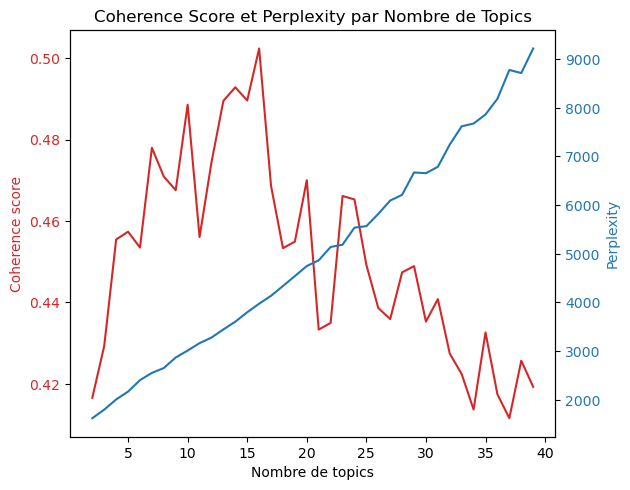

In [18]:
func.plot_coherence_and_perplexity(coherence_values, perplexity_values)

#### Sélectionner le nombre optimal de topics 

In [19]:
# Sélection du nombre optimal de topics
optimal_num_topics = range(2, 40)[coherence_values.index(max(coherence_values))]
print(f'Nombre optimal de topics: {optimal_num_topics}')

Nombre optimal de topics: 16


####  Recherche de grille pour trouver les paramètres alpha et beta optimaux

In [20]:
from joblib import parallel_backend

search_params = {
    'n_components': [optimal_num_topics],
    'learning_decay': [0.1, 0.5, 0.7, 0.9],  # Equivalent de beta
    'doc_topic_prior': [0.1, 0.5, 1.0]  # Equivalent de alpha
}

lda = LatentDirichletAllocation(random_state=42)
model_lda = GridSearchCV(lda, param_grid=search_params, n_jobs=-1, cv=3)
with parallel_backend("threading"):
    model_lda.fit(bow_train_combined)

In [ ]:
# Paramètres optimaux
lda_model = model_lda.best_estimator_
print("Best Model's Params: ", model_lda.best_params_)

Best Model's Params:  {'doc_topic_prior': 0.5, 'learning_decay': 0.5, 'n_components': 16}


#### Création et entraînement du modèle LDA avec les meilleurs paramètres

In [ ]:
lda_output  = func.lda_prediction(bow_train_combined, lda_model)

#### Fonction pour Visualiser les mots les plus importants pour chaque topic:

#### Visualisation des topics pour LDA:

In [ ]:
# optimal_num_topics = 16

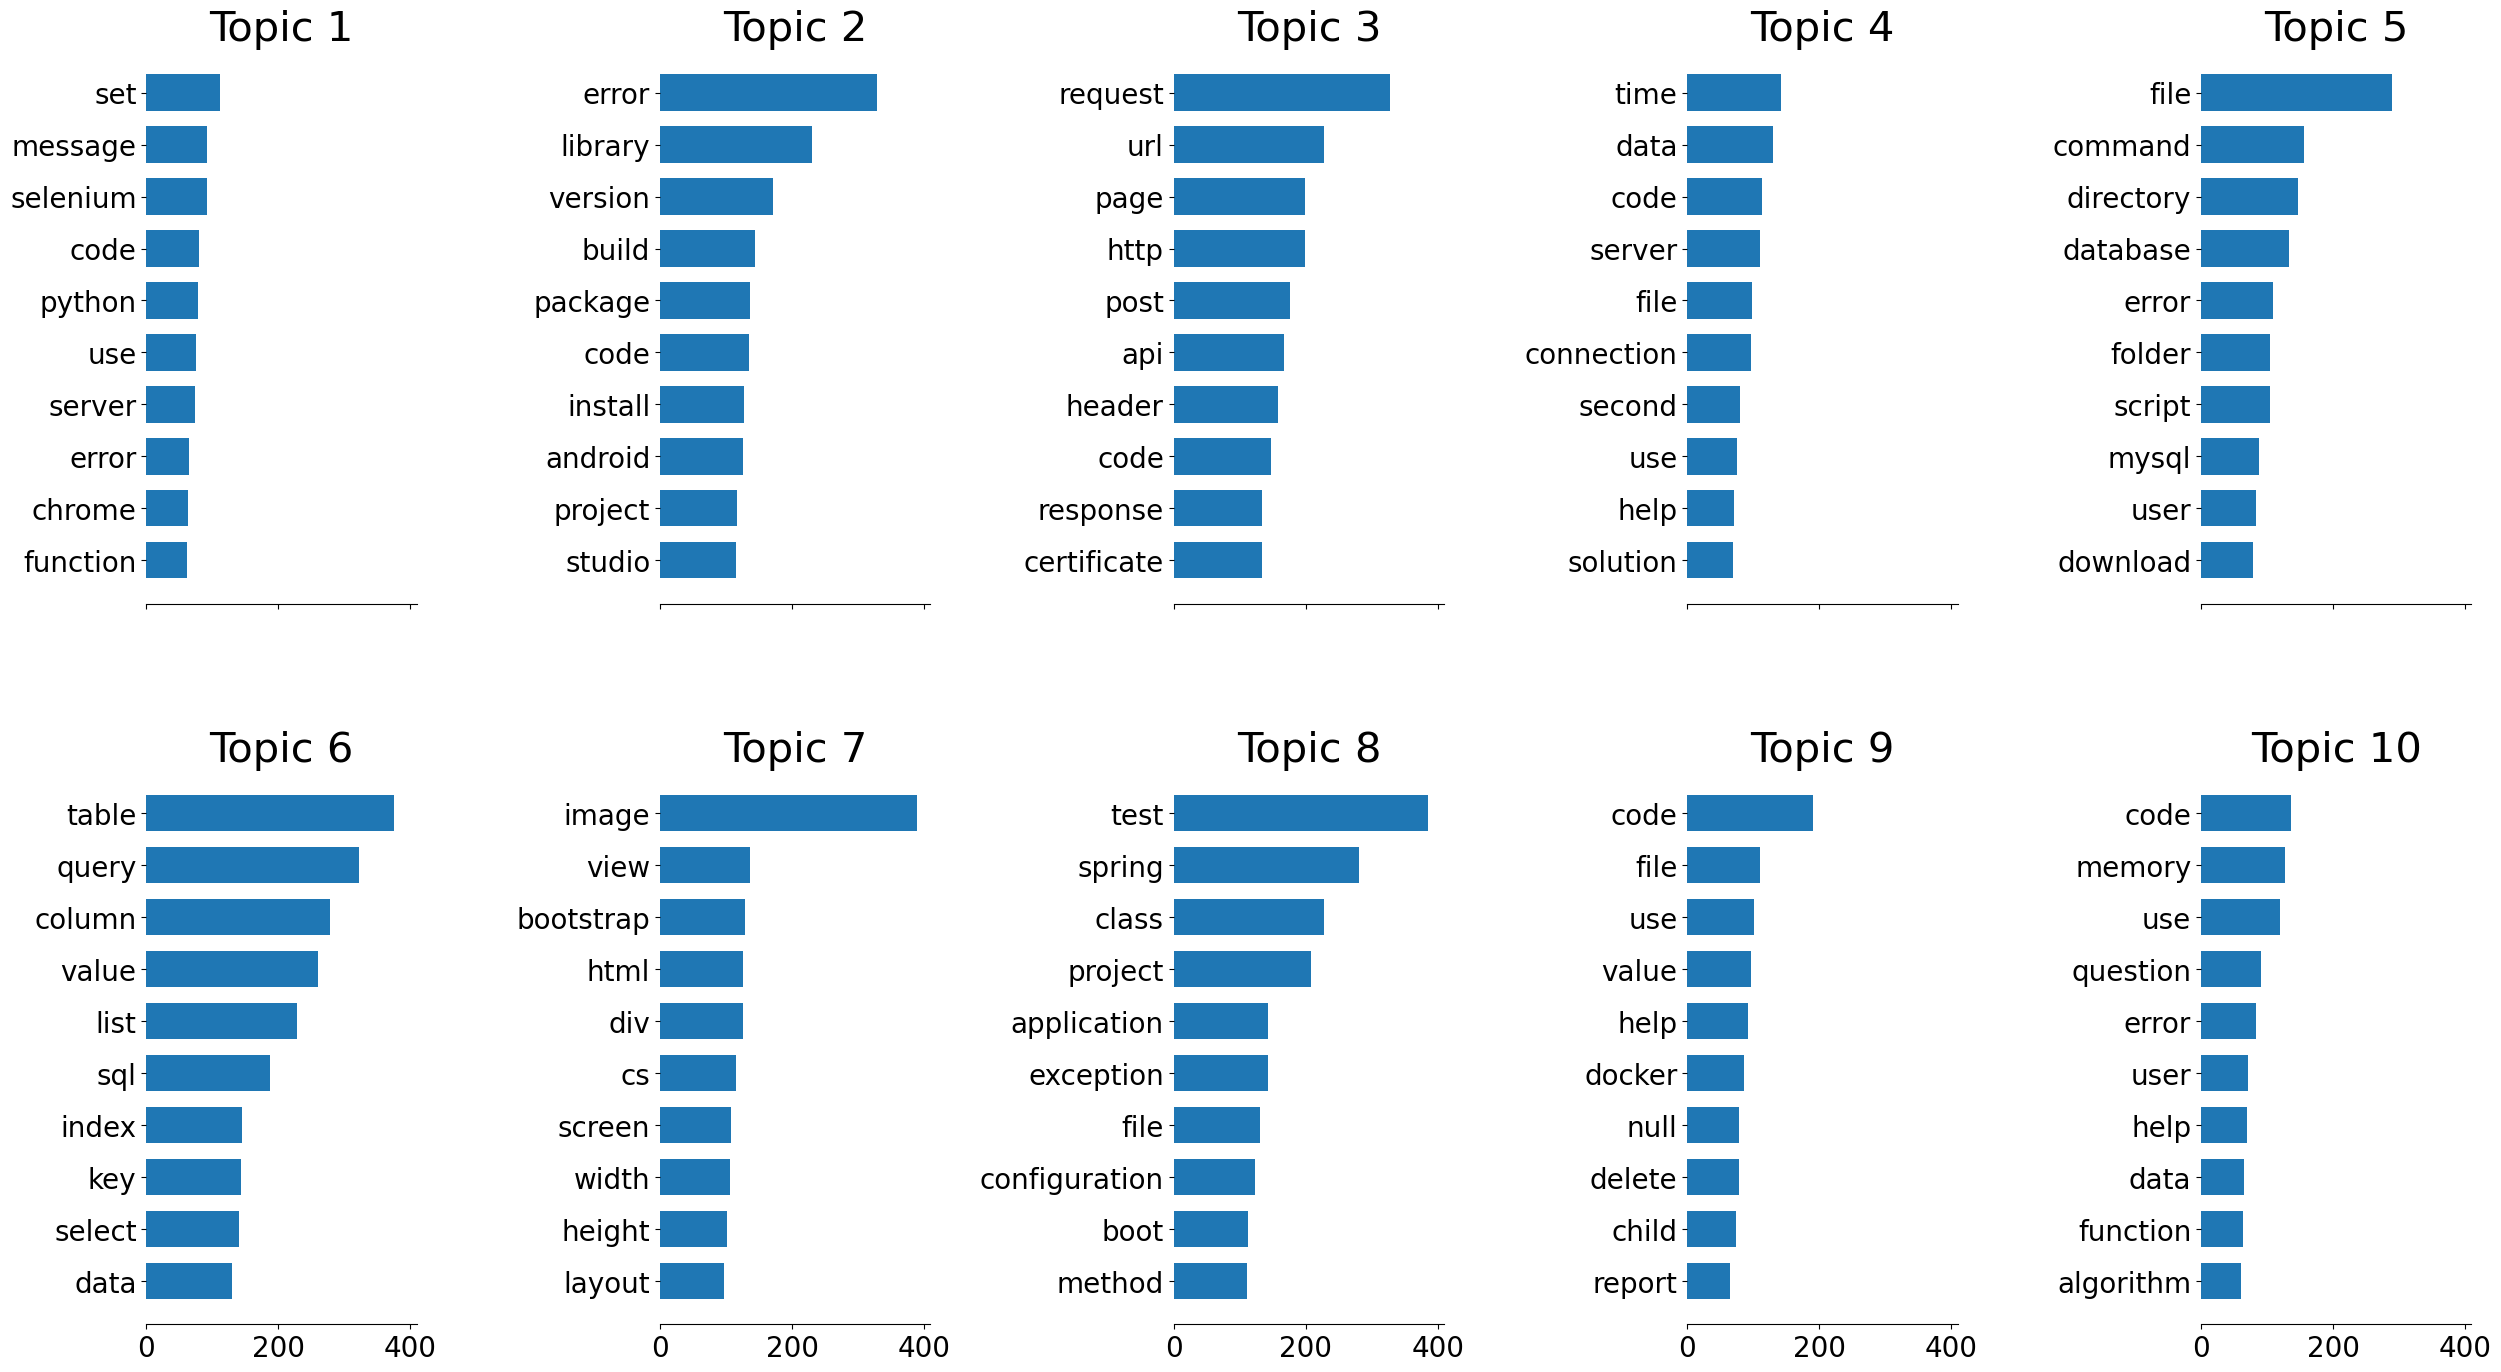

In [ ]:
n_top_words = 10  # Nombre de mots à afficher par topic
feature_names = tfidf_vectorizer.get_feature_names_out()  # Noms des caractéristiques
func.plot_top_words(lda_model , feature_names, n_top_words, 'Topics in LDA model', optimal_num_topics)

#### Enregistrer le modèle LDA au format .pkl

In [ ]:
with open('Model/unsupervised/lda_model.pkl', 'wb') as file:
    pickle.dump(lda_model, file)

#### Visualiser les topics en 2D avec t-SNE

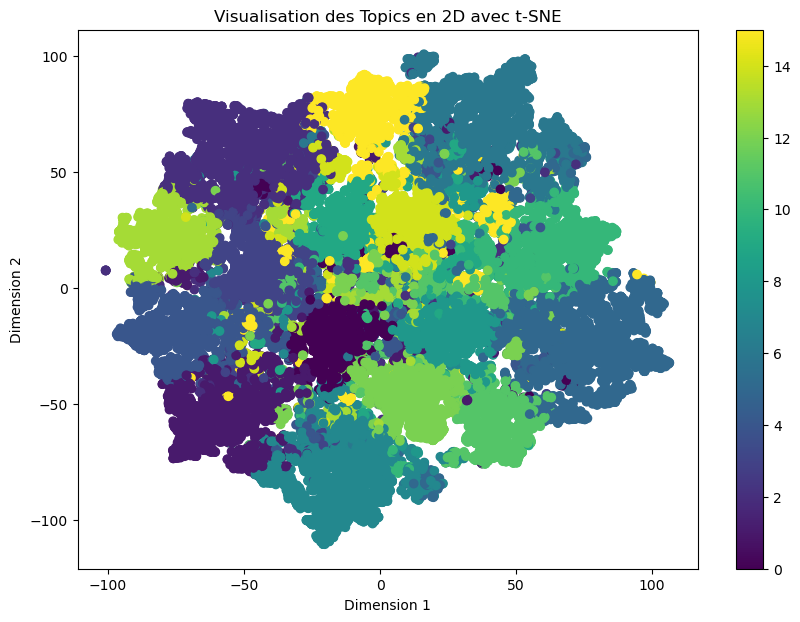

In [ ]:
func.plot_tsne_lda(lda_output)

### Création des matrices de probabilités Mtopics-words

In [ ]:
Mtopics_words_lda = lda_model.components_   # Normalisation des composantes
Mtopics_words_lda

array([[0.06250002, 0.06250004, 0.06250005, ..., 0.06250003, 0.06250003,
        0.06250007],
       [0.06250002, 0.06250003, 0.06250007, ..., 0.06250002, 0.06250004,
        0.06250004],
       [0.06250002, 0.06250002, 0.06250004, ..., 0.06250002, 0.06250002,
        0.06250012],
       ...,
       [0.06250001, 0.06250003, 0.06250007, ..., 0.06250002, 0.06250004,
        0.0625001 ],
       [0.06250002, 0.06250003, 0.06250005, ..., 0.06250002, 0.06250004,
        0.06250003],
       [0.06250002, 0.06250002, 0.06250004, ..., 0.06250004, 0.06250002,
        0.06250003]])

#### La Matrice M_train_quest-topics lda:

In [ ]:
M_train_quest_topics_lda = lda_output  # Sortie LDA pour les données d'entraînement

#### La Matrice M_test_quest-topics lda:

In [ ]:
M_test_quest_topics_lda = func.lda_prediction(bow_test_combined, lda_model)

#### Enregistrer la matrice dans un fichier .npz

In [ ]:
np.savez('Model/unsupervised/train_topics.npz', train_topics=M_train_quest_topics_lda)

#### Calcul des probabilités de mots pour les questions Train et Test avec application d'un filtre:

In [ ]:
M_train_quest_words_lda = func.calculate_words(M_train_quest_topics_lda, lda_model)

In [ ]:
M_train_quest_words_lda 

array([[0.28241836, 0.34210742, 0.1345653 , ..., 0.13237771, 0.73012182,
        0.15253246],
       [0.26500293, 0.25777486, 0.12268701, ..., 0.1350675 , 0.52876   ,
        0.16443488],
       [0.26407642, 0.51186943, 0.12026285, ..., 0.13194097, 1.13546451,
        0.14300041],
       ...,
       [0.32159578, 0.29610492, 0.13090921, ..., 0.16728601, 0.62028111,
        0.15508778],
       [0.38739035, 0.28607072, 0.13062578, ..., 0.14731246, 0.59632235,
        0.15494023],
       [0.33670666, 0.28604558, 0.12391629, ..., 0.13427269, 0.59626232,
        0.16937991]])

In [ ]:
M_test_quest_words_lda = func.calculate_words(M_test_quest_topics_lda, lda_model)

In [ ]:
M_test_quest_words_lda

array([[0.31452968, 0.81495134, 0.13014789, ..., 0.13572247, 1.85913667,
        0.15552514],
       [0.61876653, 0.27521819, 0.12453721, ..., 0.1368009 , 0.57040962,
        0.14829926],
       [0.29252135, 0.28911411, 0.12934235, ..., 0.13411174, 0.60358907,
        0.15302428],
       ...,
       [0.27418199, 0.27529956, 0.12416125, ..., 0.13313485, 0.57060391,
        0.1454888 ],
       [0.32245651, 0.26631663, 0.17214902, ..., 0.13417471, 0.54915527,
        0.16662126],
       [0.28390115, 0.26333031, 0.12449071, ..., 0.15637021, 0.54202481,
        0.15510378]])

##### Application d'un seuil pour ne garder que les principaux mots:

In [ ]:
M_test_quest_words_filtered_lda = func.filter_words(M_test_quest_words_lda, lda_model, threshold=0.01)

In [ ]:
M_test_quest_words_filtered_lda

array([[0.31452968, 0.81495134, 0.13014789, ..., 0.13572247, 1.85913667,
        0.15552514],
       [0.61876653, 0.27521819, 0.12453721, ..., 0.1368009 , 0.57040962,
        0.14829926],
       [0.29252135, 0.28911411, 0.12934235, ..., 0.13411174, 0.60358907,
        0.15302428],
       ...,
       [0.27418199, 0.27529956, 0.12416125, ..., 0.13313485, 0.57060391,
        0.1454888 ],
       [0.32245651, 0.26631663, 0.17214902, ..., 0.13417471, 0.54915527,
        0.16662126],
       [0.28390115, 0.26333031, 0.12449071, ..., 0.15637021, 0.54202481,
        0.15510378]])

#### Création de DataFrames avec les mots clés proposés

In [ ]:
words = tfidf_vectorizer.get_feature_names_out()
df_keywords_test_lda = pd.DataFrame(M_test_quest_words_filtered_lda, columns=words, index=test_df.index)
df_keywords_test_lda

,0x,__init__,__init__py,__name__,__str__,_files,_id,_post,aa,aad,...,zlib,zod,zombie,zone,zoneddatetime,zookeeper,zoom,zpl,zsh,zuul
0,0.314530,0.814951,0.130148,0.118427,0.124109,0.098492,0.125961,0.121953,0.315329,0.137314,...,0.248479,0.172136,0.252741,1.139922,0.273838,0.270707,1.289085,0.135722,1.859137,0.155525
1,0.618767,0.275218,0.124537,0.116847,0.118762,0.095696,0.131818,0.113601,0.249509,0.126804,...,0.222352,0.163620,0.425394,1.046413,0.255496,0.319237,1.192029,0.136801,0.570410,0.148299
2,0.292521,0.289114,0.129342,0.118211,0.128898,0.097525,0.124818,0.118587,0.261139,0.133078,...,0.237949,0.169188,0.226703,1.223677,0.290266,0.278941,1.274078,0.134112,0.603589,0.153024
3,0.330242,0.293707,0.125920,0.119698,0.118436,0.097428,0.122343,0.118567,0.251871,0.133054,...,0.237888,0.168894,0.212020,1.040712,0.254378,0.275759,1.228099,0.143206,0.614556,0.152775
4,0.301131,0.295940,0.142829,0.122403,0.150509,0.109364,0.127703,0.126518,0.257000,0.143059,...,0.262759,0.205253,0.445179,1.601616,0.364400,0.418636,1.516619,0.139749,0.619887,0.183625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.347953,0.282793,0.119554,0.142451,0.126362,0.111519,0.186258,0.148936,0.216077,0.171269,...,0.332885,0.211815,0.232651,1.179337,0.281569,0.326975,1.104260,0.123306,0.588496,0.189193
9996,0.374575,0.385397,0.127741,0.121141,0.179187,0.099561,0.124679,0.131522,0.362814,0.149356,...,0.278413,0.175392,0.246002,2.103136,0.462773,0.260830,1.298711,0.151148,0.833484,0.158288
9997,0.274182,0.275300,0.124161,0.156054,0.169637,0.094609,0.123291,0.163301,0.460613,0.189345,...,0.377821,0.160307,0.216980,1.936129,0.430015,0.256814,1.180937,0.133135,0.570604,0.145489
9998,0.322457,0.266317,0.172149,0.137281,0.226609,0.102785,0.120397,0.115490,0.251788,0.129181,...,0.228261,0.185213,0.240585,2.932460,0.625446,0.265784,2.035117,0.134175,0.549155,0.166621


## Tester le model NMF:

#### Recherche de grille pour trouver les paramètres alpha et l1_ratio optimaux pour NMF:

In [ ]:
# Configuration des paramètres pour NMF
search_params_nmf = {
    'n_components': [optimal_num_topics],
    'alpha_H': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1],  # Utilisation de alpha_H
    'l1_ratio': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.9]
}

# Modèle NMF
nmf = NMF(random_state=42)

# Définition du GridSearchCV pour NMF
model_nmf = GridSearchCV(nmf, param_grid=search_params_nmf, scoring='neg_log_loss', n_jobs=-1, cv=3)

# Ajustement du modèle avec parallélisation
with parallel_backend("threading"):
    model_nmf.fit(bow_train_combined)

# Affichage des meilleurs paramètres
print("Meilleurs paramètres pour NMF:", model_nmf.best_params_)

Meilleurs paramètres pour NMF: {'alpha_H': 0.0001, 'l1_ratio': 0.0001, 'n_components': 16}


#### Paramètres optimaux pour NMF

In [ ]:
nmf_model = model_nmf.best_estimator_
print("Best NMF Model's Params: ", model_nmf.best_params_)

Best NMF Model's Params:  {'alpha_H': 0.0001, 'l1_ratio': 0.0001, 'n_components': 16}


In [ ]:
nmf_output = nmf_model.fit_transform(bow_train_combined)  # Ajustement et transformation des données d'entraînement

#### Visualisation des topics pour NMF

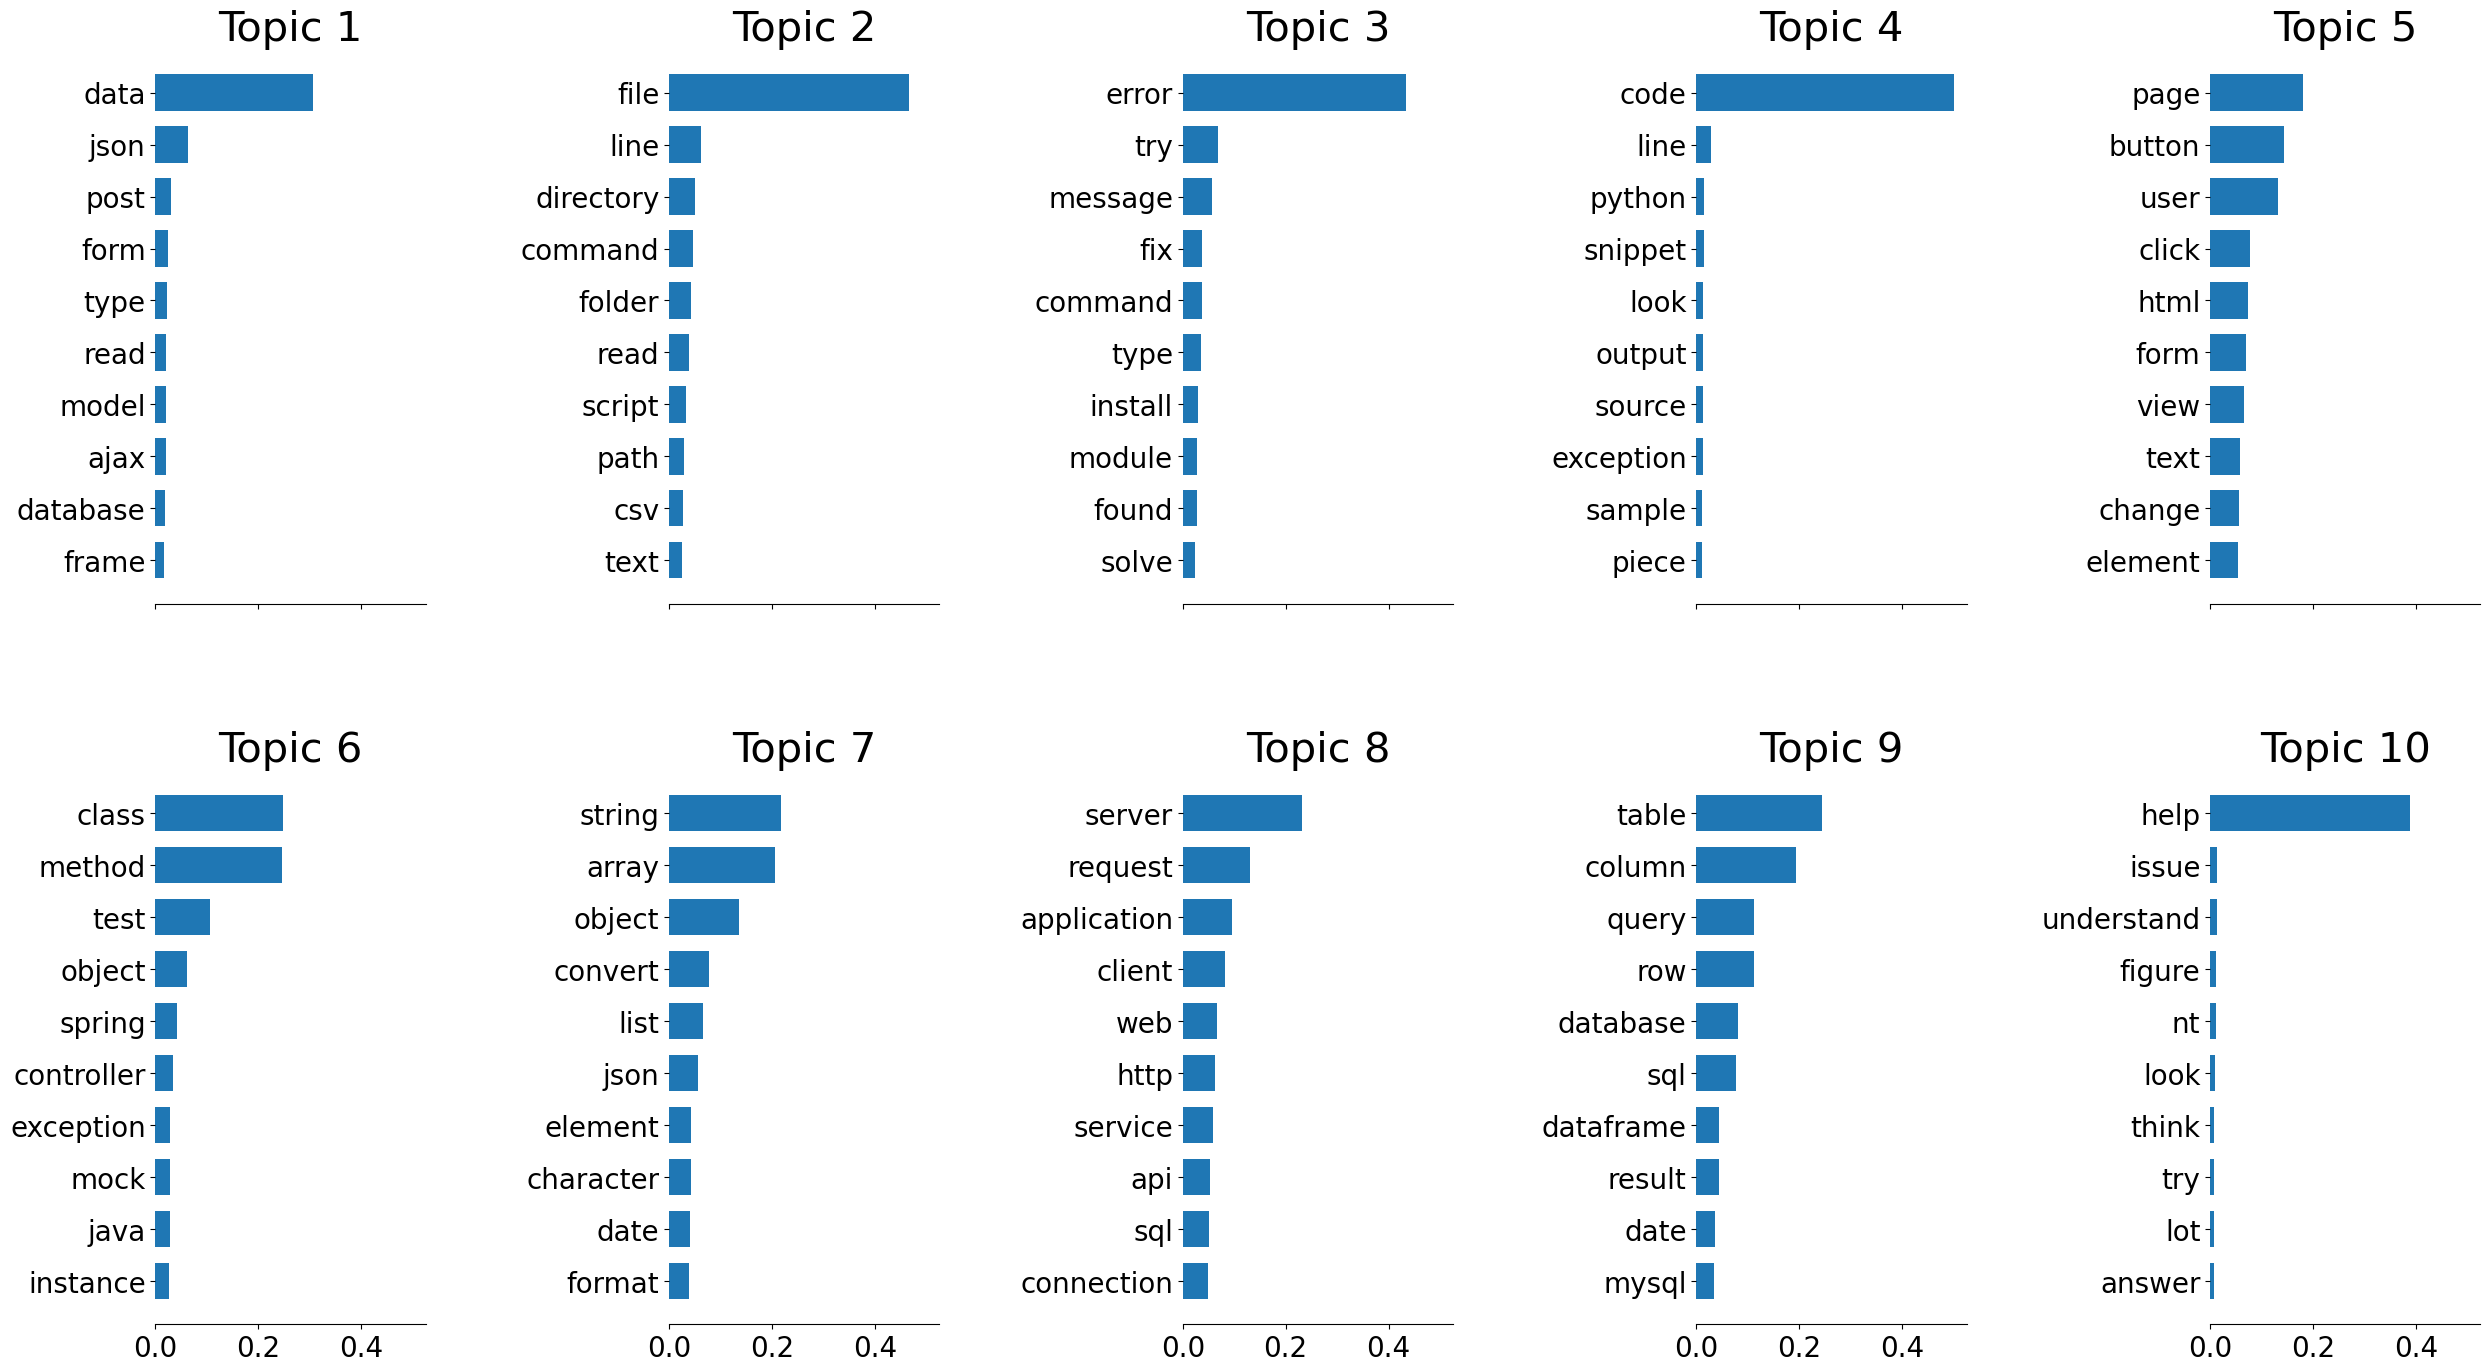

In [ ]:
func.plot_top_words(nmf_model, tfidf_vectorizer.get_feature_names_out(), n_top_words, 'Topics in NMF model', optimal_num_topics)

#### Création des matrices de probabilités

In [ ]:
Mtopics_words_nmf = nmf_model.components_ 

In [ ]:
M_train_quest_topics_nmf = nmf_output  # Sortie NMF pour les données d'entraînement
M_test_quest_topics_nmf = func.lda_prediction(bow_test_combined, nmf_model) # Transformation des données de test

#### Calcul des probabilités de mots pour les questions Train et Test

In [ ]:
M_train_quest_words_nmf = func.calculate_words(M_train_quest_topics_nmf, nmf_model)  # Multiplication matricielle pour les données d'entraînement

In [ ]:
M_train_quest_words_nmf

array([[1.79196543e-03, 1.36428327e-04, 9.61398610e-04, ...,
        8.78181728e-04, 1.44853160e-04, 4.32026178e-04],
       [2.78875576e-03, 3.33619101e-03, 5.35368293e-04, ...,
        1.39558131e-04, 4.69851173e-05, 7.82473832e-05],
       [0.00000000e+00, 4.73947219e-02, 7.15519483e-03, ...,
        0.00000000e+00, 3.03911534e-05, 4.70693288e-04],
       ...,
       [5.72799622e-04, 0.00000000e+00, 7.93406454e-05, ...,
        1.46274877e-04, 9.09280927e-05, 3.50651618e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.93974566e-05, 2.99825054e-05, 0.00000000e+00],
       [9.24923260e-02, 5.87852919e-03, 1.25492663e-03, ...,
        8.67654022e-05, 7.48151527e-04, 6.94942272e-05]])

In [ ]:
M_test_quest_words_nmf = func.calculate_words(M_test_quest_topics_nmf, nmf_model) # Multiplication matricielle pour les données de test

In [ ]:
M_test_quest_words_nmf

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.11979930e-05, 1.15915435e-04, 0.00000000e+00],
       [0.00000000e+00, 2.47654372e-02, 0.00000000e+00, ...,
        1.90427556e-05, 1.12673174e-04, 2.08051507e-06],
       [2.78899600e-03, 2.00230455e-03, 0.00000000e+00, ...,
        3.46604683e-04, 1.22993545e-04, 2.18706704e-04],
       ...,
       [2.94167001e-02, 2.28373272e-03, 2.07183262e-04, ...,
        1.05449066e-04, 2.08841912e-04, 8.43440276e-05],
       [2.68325318e-02, 0.00000000e+00, 0.00000000e+00, ...,
        9.73499576e-05, 2.64658764e-04, 2.02896061e-05],
       [1.74416892e-01, 3.90548595e-03, 2.55307627e-02, ...,
        6.30005257e-05, 1.08931750e-03, 2.33008247e-05]])

# Application d'un seuil pour ne garder que les principaux mots

In [ ]:
M_test_quest_words_filtered_nmf = func.filter_words(M_test_quest_words_nmf, nmf_model, threshold=0.01)  # Filtrage des mots basés sur le seuil

#### Création de DataFrames avec les mots clés proposés

In [ ]:
df_keywords_test_nmf = pd.DataFrame(M_test_quest_words_filtered_nmf, columns=words, index=test_df.index)

In [ ]:
df_keywords_test_nmf

,file,error,code,use,data,value,server,function,method,class,...,excel,mac,filter,label,throw,firefox,network,width,word,iphone
0,0.000000,0.000000,0.000000,0.000235,0.000000,0.019885,0.000481,0.002288,0.000038,0.000041,...,0.000110,0.000001,0.000258,0.000352,0.000075,0.000004,0.000017,0.000011,0.000116,0.000000
1,0.000000,0.024765,0.000000,0.000526,0.000060,0.019385,0.000000,0.000332,0.000018,0.000000,...,0.000115,0.000148,0.000256,0.000357,0.000547,0.000093,0.000008,0.000019,0.000113,0.000002
2,0.002789,0.002002,0.000000,0.000786,0.008299,0.008360,0.010132,0.000000,0.005689,0.007655,...,0.000332,0.000085,0.000248,0.000436,0.000237,0.000411,0.000335,0.000347,0.000123,0.000219
3,0.000000,0.070800,0.000000,0.000000,0.007235,0.000000,0.009491,0.000000,0.001559,0.000981,...,0.000215,0.000490,0.000464,0.000728,0.001562,0.001201,0.000422,0.000888,0.000232,0.000453
4,0.008203,0.002876,0.001392,0.001389,0.002593,0.002561,0.000150,0.001603,0.002091,0.002780,...,0.000214,0.000082,0.000104,0.000129,0.000125,0.000119,0.000055,0.000084,0.000108,0.000029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000000,0.002457,0.008396,0.000275,0.009566,0.004783,0.000000,0.001199,0.012935,0.001102,...,0.000359,0.000023,0.000757,0.000249,0.000451,0.000074,0.000141,0.000024,0.002919,0.000013
9996,0.031402,0.000700,0.002740,0.004655,0.002797,0.002901,0.000000,0.005090,0.000546,0.000206,...,0.000616,0.000231,0.000201,0.000243,0.000075,0.000285,0.000139,0.000331,0.000312,0.000198
9997,0.029417,0.002284,0.000207,0.000461,0.000000,0.002499,0.000662,0.000000,0.000084,0.000000,...,0.000477,0.000161,0.000094,0.000103,0.000069,0.000154,0.000042,0.000105,0.000209,0.000084
9998,0.026833,0.000000,0.000000,0.012710,0.000000,0.000000,0.000000,0.000304,0.000464,0.000000,...,0.000390,0.000178,0.000080,0.000089,0.000055,0.000168,0.000149,0.000097,0.000265,0.000020


### Approche semi-supervisée

In [ ]:
similarity_matrix_lda = cosine_similarity(M_test_quest_topics_lda, M_train_quest_topics_lda)  # Matrice de similarité pour LDA
similarity_matrix_nmf = cosine_similarity(M_test_quest_topics_nmf, M_train_quest_topics_nmf)  # Matrice de similarité pour NMF

In [ ]:
vectorizer_tags = TfidfVectorizer(max_features=5000)  # Vectoriseur pour les tags
X_tags = vectorizer_tags.fit_transform(train_df['split_tags'])  # Transformation des tags d'entraînement

In [ ]:
with open('Model/unsupervised/vectorizer_tags.pkl', 'wb') as file:
    pickle.dump(vectorizer_tags, file)

#### Évaluation comparative L

In [ ]:
tags_train = X_tags.toarray()  # Conversion en array numpy

keywords_test_semi_supervised_lda = np.dot(similarity_matrix_lda, tags_train)  # Mots clés semi-supervisés pour LDA
keywords_test_semi_supervised_nmf = np.dot(similarity_matrix_nmf, tags_train)  # Mots clés semi-supervisés pour NMF

In [ ]:
np.savez('Model/unsupervised/tags_train.npz', tags_train=tags_train)

In [ ]:
tags = vectorizer_tags.get_feature_names_out()
df_keywords_test_semi_supervised_lda = pd.DataFrame(keywords_test_semi_supervised_lda, columns=tags, index=test_df.index)
df_keywords_test_semi_supervised_nmf = pd.DataFrame(keywords_test_semi_supervised_nmf, columns=tags, index=test_df.index)

In [ ]:
df_keywords_test_semi_supervised_lda

,03,10gen,10x,11,12,14,16le,17,1x,20,...,zscaler,zsh,zshrc,zsi,zstack,zstandard,zurb,zuul,zxing,zynq
0,0.533264,0.031743,0.049083,33.317931,0.683969,1.854638,0.040638,0.714087,0.401792,0.476026,...,0.171816,3.189154,0.563700,0.065340,0.045722,0.403870,0.645391,0.287015,1.012077,0.075081
1,0.810415,0.069008,0.265801,20.585441,1.067910,1.891848,0.057741,1.080025,0.056898,0.359095,...,0.320115,5.003025,1.383885,0.192136,0.030607,0.114921,0.549216,0.097029,0.453003,0.448447
2,0.499978,0.139789,0.027747,22.901162,2.068134,2.285516,0.016690,1.168405,0.039551,0.586203,...,0.346631,1.934339,0.103688,1.686626,0.021303,0.022055,0.292369,4.234488,0.300998,0.033437
3,0.485586,0.473656,0.223718,18.488087,2.654569,1.998092,0.047514,1.527225,0.096185,0.633649,...,0.639537,5.179561,1.295830,1.726838,0.206520,0.096623,0.659807,4.021589,0.637069,0.366102
4,0.817978,0.026736,0.047065,41.459039,2.441091,4.551492,0.573368,1.166276,0.877702,0.679672,...,0.898628,12.619923,0.534244,0.157324,0.817918,0.124894,0.655641,0.252548,0.917776,0.173068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.184477,0.113540,0.034996,52.423033,1.402422,4.560201,0.170006,3.163668,0.050152,1.734054,...,0.110017,1.407521,0.369217,0.044628,0.027011,0.027964,0.727277,0.242127,0.191986,0.042456
9996,0.866251,0.042627,0.039739,26.665171,1.867310,2.667447,0.437471,1.159901,0.612681,0.700192,...,0.564747,9.602346,0.436936,0.169068,0.569326,0.032352,0.722207,0.407148,0.847444,0.049354
9997,0.314298,0.109834,0.434087,33.896682,7.316190,3.930356,0.088884,2.621831,0.355097,0.548989,...,0.518637,11.551493,3.013434,0.361443,0.042211,0.768491,0.913306,0.782507,1.094645,1.136577
9998,0.649429,0.125615,0.047969,82.368001,2.195220,8.348746,0.039716,2.353201,0.083119,1.226606,...,0.167501,2.782074,0.569966,0.102986,0.144861,0.250278,1.882598,0.540943,0.441349,0.213188


In [ ]:
df_keywords_test_semi_supervised_nmf

,03,10gen,10x,11,12,14,16le,17,1x,20,...,zscaler,zsh,zshrc,zsi,zstack,zstandard,zurb,zuul,zxing,zynq
0,1.107331,0.002374,0.000000,45.836464,0.764612,4.141603,0.000163,0.672409,0.004431,0.381330,...,0.060084,6.190912,0.368932,0.276561,0.054327,0.000417,0.243224,0.152486,0.047495,0.156572
1,1.028356,0.443069,0.555893,54.095054,1.975792,7.027112,0.254981,1.729251,0.073699,0.672436,...,0.596767,12.716322,2.714093,0.491556,0.052528,0.003998,0.743666,0.445553,0.375546,0.994735
2,0.660680,0.383878,0.045961,52.259399,2.534443,5.277653,0.064995,0.970080,0.080390,0.269111,...,0.735709,9.957149,1.660253,1.324471,0.500342,0.071693,1.194773,2.344824,0.960523,0.666128
3,0.257592,0.551492,0.586974,33.926842,3.003416,5.679268,0.288043,1.903916,0.482008,0.318794,...,1.090024,13.473706,3.532400,0.904136,0.467060,0.007395,1.498977,1.515207,0.692416,1.298732
4,1.545063,0.486862,0.222465,80.927173,7.519424,7.711122,0.363233,3.461820,0.608451,1.052050,...,0.962483,19.018074,3.348633,1.008287,0.482264,0.560854,1.806238,2.245056,2.740487,1.028808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.697514,0.268710,0.032611,17.864945,0.236888,1.476833,0.028599,1.138374,0.005818,0.958193,...,0.059373,1.229615,0.265354,0.100006,0.065428,0.000104,0.049884,0.159923,0.113958,0.068954
9996,1.736940,0.072020,0.048228,55.508214,9.397691,5.039656,0.535889,3.301893,0.278499,0.913508,...,0.704412,17.728071,2.979140,0.671742,0.478796,0.846487,1.541796,1.439139,2.804633,0.846191
9997,1.594628,0.082494,0.074150,31.046355,9.619993,2.425170,0.590873,2.315594,0.213896,0.257535,...,0.480675,15.872361,2.843907,0.500596,0.297795,0.955700,1.013875,1.090848,2.125201,0.792549
9998,1.830018,0.021950,0.000000,49.343484,9.031262,4.445207,0.383994,3.947786,0.121836,1.921191,...,0.649841,15.667609,2.336669,0.340606,0.224252,0.798743,0.855753,1.211145,2.159072,0.562789


#### Taux de couverture des tags:

In [ ]:
def coverage_rate(predicted_tags, actual_tags):
    """
    Calcule le taux de couverture entre les tags prédits et les tags réels.
    """
    matches = np.sum((predicted_tags > 0) & (actual_tags > 0), axis=1)  # Comptage des correspondances
    total = np.sum(actual_tags > 0, axis=1)  # Comptage des tags réels
    return np.mean(matches / total)  # Calcul du taux de couverture moyen

#### Calcul du taux de couverture des tags réels

In [ ]:
actual_tags_test = vectorizer_tags.transform(test_df['split_tags']).toarray()
coverage_lda = func.coverage_rate(keywords_test_semi_supervised_lda, actual_tags_test)  # Taux de couverture pour LDA
coverage_nmf = func.coverage_rate(keywords_test_semi_supervised_nmf, actual_tags_test)  # Taux de couverture pour NMF

#### Calcul du taux de couverture des mots des questions

In [ ]:
actual_words_test = tfidf_vectorizer.transform(test_df['combined_title_body']).toarray()
coverage_words_lda = func.coverage_rate(M_test_quest_words_filtered_lda, actual_words_test)  # Taux de couverture des mots pour LDA
coverage_words_nmf = func.coverage_rate(M_test_quest_words_filtered_nmf, actual_words_test)  # Taux de couverture des mots pour NMF

C:\Users\bille\AppData\Local\Temp\ipykernel_29872\4227865348.py:7: RuntimeWarning: invalid value encountered in divide
  return np.mean(matches / total)  # Calcul du taux de couverture moyen


#### Visualisation de la distribution des topics

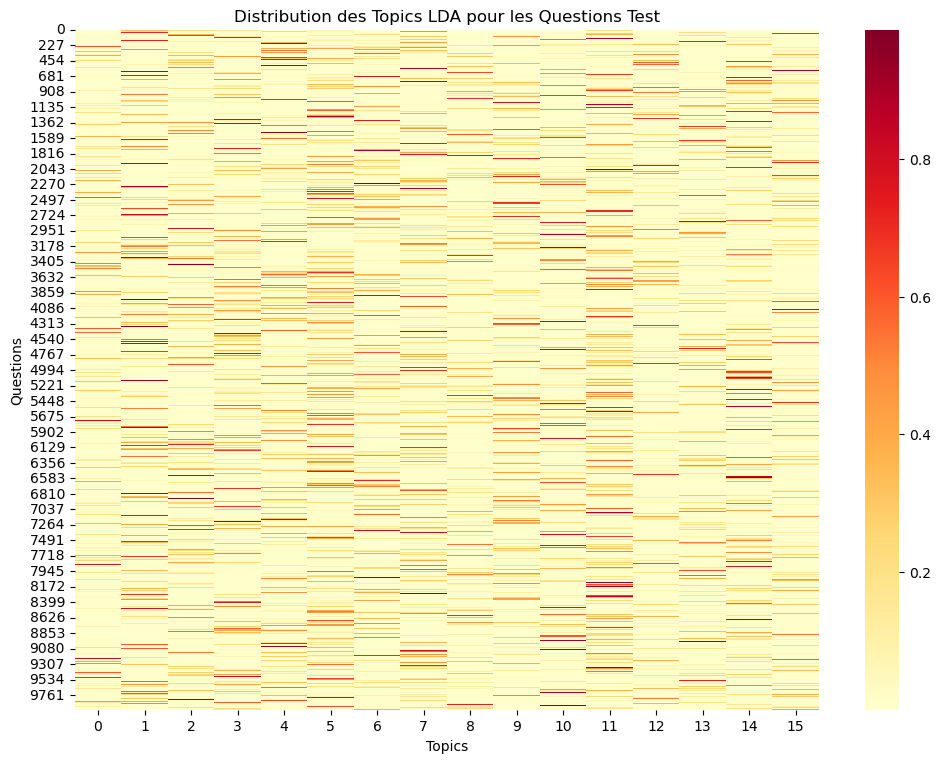

In [ ]:
# Créer la heatmap pour les topics LDA
func.plot_heatmap(M_test_quest_topics_lda, 'Distribution des Topics LDA pour les Questions Test')

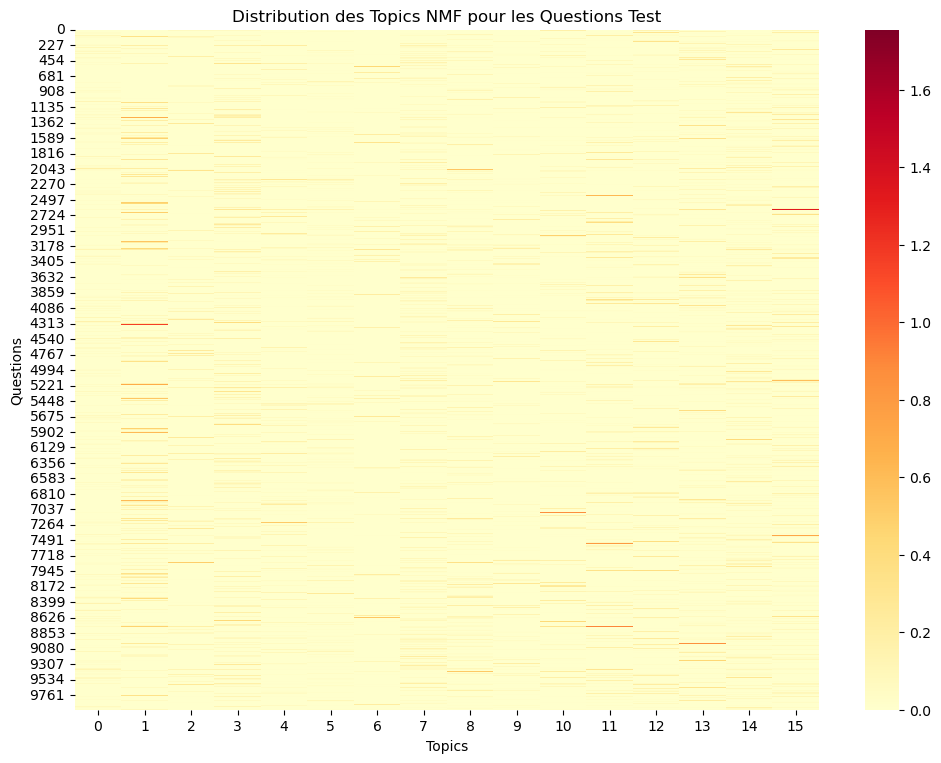

In [ ]:
# Créer la heatmap pour les topics NMF
func.plot_heatmap(M_test_quest_topics_nmf, 'Distribution des Topics NMF pour les Questions Test')

#### Test de visu sur quelques questions

In [ ]:
sample_indices = np.random.choice(test_df.index, 5, replace=False)  # Sélection aléatoire de quelques indices

for i in sample_indices:
    print(f"Question: {test_df.loc[i, 'combined_title_body']}")
    print(f"Tags réels: {test_df.loc[i, 'split_tags']}")
    print(f"Mots clés proposés (LDA): {df_keywords_test_lda.loc[i].nlargest(5).index.tolist()}")  # Mots clés proposés par LDA
    print(f"Mots clés proposés (NMF): {df_keywords_test_nmf.loc[i].nlargest(5).index.tolist()}")  # Mots clés proposés par NMF
    print(f"Mots clés semi-supervisés (LDA): {df_keywords_test_semi_supervised_lda.loc[i].nlargest(5).index.tolist()}")  # Mots clés semi-supervisés par LDA
    print(f"Mots clés semi-supervisés (NMF): {df_keywords_test_semi_supervised_nmf.loc[i].nlargest(5).index.tolist()}")  # Mots clés semi-supervisés par NMF
    print("--------------------------------------------------")

Question: android http request send http request google shopping api moment suggestion thanks advance
Tags réels: ['android', 'http', 'https', 'get', 'httpclient']
Mots clés proposés (LDA): ['request', 'api', 'change', 'service', 'http']
Mots clés proposés (NMF): ['data', 'server', 'app', 'application', 'request']
Mots clés semi-supervisés (LDA): ['java', 'android', 'javascript', 'python', 'spring']
Mots clés semi-supervisés (NMF): ['android', 'javascript', 'java', 'python', 'sql']
--------------------------------------------------
Question: symfony2 formbuilder class field input class input label element symfony application form twig level setup write template form use cs class label input think configure form place
Tags réels: ['css', 'class', 'input', 'symfony', 'formbuilder']
Mots clés proposés (LDA): ['form', 'code', 'event', 'image', 'url']
Mots clés proposés (NMF): ['class', 'method', 'use', 'object', 'user']
Mots clés semi-supervisés (LDA): ['javascript', 'java', 'jquery', 'pyt

#### Évaluation comparative LDA vs NMF

In [ ]:
print("Comparaison LDA vs NMF:")
print(f"Taux de couverture des tags réels - LDA: {coverage_lda:.2f}, NMF: {coverage_nmf:.2f}")
print(f"Taux de couverture des mots des questions - LDA: {coverage_words_lda:.2f}, NMF: {coverage_words_nmf:.2f}")

Comparaison LDA vs NMF:
Taux de couverture des tags réels - LDA: 1.00, NMF: 1.00
Taux de couverture des mots des questions - LDA: nan, NMF: nan


In [ ]:
# # Sauvegarde des résultats
# results = {
#     'lda_keywords': df_keywords_test_lda,  # Mots clés LDA
#     'nmf_keywords': df_keywords_test_nmf,  # Mots clés NMF
#     'lda_semi_supervised': df_keywords_test_semi_supervised_lda,  # Mots clés semi-supervisés LDA
#     'nmf_semi_supervised': df_keywords_test_semi_supervised_nmf  # Mots clés semi-supervisés NMF
# }

# for name, df in results.items():
#     df.to_csv(f'{name}_results.csv')  # Sauvegarde des DataFrames en fichiers CSV

# print("Analyse terminée. Les résultats ont été sauvegardés.")

### Création d'un code à tester avant de l'implémenter dans la future API :

#### Charger les modèles et les matrices:

In [ ]:
with open('Model/unsupervised/lda_model.pkl', 'rb') as file:
    lda_model = pickle.load(file)

with open('Model/unsupervised/tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer= pickle.load(file)
    
with open('Model/unsupervised/vectorizer_tags.pkl', 'rb') as file:
    vectorizer_tags = pickle.load(file)
    
# Charger la matrice des topics depuis le fichier compressé NPZ
file_path_topics = 'Model/unsupervised/train_topics.npz'
with np.load(file_path_topics) as data:
    train_topics = data['train_topics']

# Charger la matrice des tags depuis le fichier compressé NPZ
file_path_tags = 'Model/unsupervised/tags_train.npz'
with np.load(file_path_tags) as data:
    tags_train = data['tags_train']

#### Tester le code:

#### library :

In [ ]:
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
# import re
# import pandas as pd
# import numpy as np
# import pickle
# from bs4 import BeautifulSoup
# from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# exemple de texte
texte = '''<p>Failed Attempts to Delete a Remote Branch:</p>
<pre class="lang-bash prettyprint-override"><code>$ git branch -d remotes/origin/bugfix
error: branch 'remotes/origin/bugfix' not found.

$ git branch -d origin/bugfix
error: branch 'origin/bugfix' not found.

$ git branch -rd origin/bugfix
Deleted remote branch origin/bugfix (was 2a14ef7).

$ git push
Everything up-to-date

$ git pull
From github.com:gituser/gitproject

* [new branch] bugfix -&gt; origin/bugfix
Already up-to-date.
</code></pre>
<p>How do I properly delete the <code>remotes/origin/bugfix</code> branch both locally and remotely?</p>'''



print(texte)

<p>Failed Attempts to Delete a Remote Branch:</p>
<pre class="lang-bash prettyprint-override"><code>$ git branch -d remotes/origin/bugfix
error: branch 'remotes/origin/bugfix' not found.

$ git branch -d origin/bugfix
error: branch 'origin/bugfix' not found.

$ git branch -rd origin/bugfix
Deleted remote branch origin/bugfix (was 2a14ef7).

$ git push
Everything up-to-date

$ git pull
From github.com:gituser/gitproject

* [new branch] bugfix -&gt; origin/bugfix
Already up-to-date.
</code></pre>
<p>How do I properly delete the <code>remotes/origin/bugfix</code> branch both locally and remotely?</p>


In [ ]:
# Exemple d'utilisation directe
user_input = texte

if user_input:
    # Nettoyage et tokenisation du texte d'entrée
    cleaned_html_input = func.clean_html(user_input)
    cleaned_input = func.process_clean_text(cleaned_html_input)
    
    predicted_keywords, predicted_semi_supervised_keywords = func.predict_keywords(
        cleaned_input, lda_model, tfidf_vectorizer, train_topics, tags_train, vectorizer_tags)
    print("---------------------------------------")
    print("le texte nettoyé:", cleaned_input)
    print("---------------------------------------")
    print('Mots-clés prédits avec LDA model:')
    print(predicted_keywords)
    print('Mots-clés semi-supervisés prédits:')
    print(predicted_semi_supervised_keywords)
else:
    print("Veuillez entrer du texte pour la prédiction.")


---------------------------------------
le texte nettoyé: attempt delete remote branch delete branch
---------------------------------------
Mots-clés prédits avec LDA model:
['code', 'error', 'file', 'use', 'help']
Mots-clés semi-supervisés prédits:
['python', 'java', 'javascript', 'android', 'sql']
